# Auto Insurance Classification Test

Notebook to solve the ["Kaggle Auto Insurance 2017 Challenge"](https://www.kaggle.com/competitions/auto-insurance-fall-2017/overview/evaluation)

We are presented with a supervised binary classification problem, in which we have to predict based on the car and client features if the client's loss claim would be accepted or not.

## Import libraries and data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV, cross_validate
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
import category_encoders as ce
from sklearn.feature_selection import SelectKBest

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from catboost import CatBoostClassifier
import xgboost as xgb
import lightgbm as lgb

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer

import missingno as msno
import seaborn as sns

In [3]:
assurance_df_train = pd.read_csv('data/train_auto.csv')
assurance_df_test = pd.read_csv('data/test_auto.csv')

## 1- Exploratory Data Analysis
To begin to tackle a ML problem, it is necessary to first understand and clean the given dataset, so to obtain a clear picture of the features, the label and the relationships between them.


In [4]:
print(assurance_df_train.shape)
assurance_df_train.head()

(8161, 26)


,INDEX,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,...,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
0,1,0,0.0,0,60.0,0,11.0,"$67,349",No,$0,...,"$14,230",11,Minivan,yes,"$4,461",2,No,3,18.0,Highly Urban/ Urban
1,2,0,0.0,0,43.0,0,11.0,"$91,449",No,"$257,252",...,"$14,940",1,Minivan,yes,$0,0,No,0,1.0,Highly Urban/ Urban
2,4,0,0.0,0,35.0,1,10.0,"$16,039",No,"$124,191",...,"$4,010",4,z_SUV,no,"$38,690",2,No,3,10.0,Highly Urban/ Urban
3,5,0,0.0,0,51.0,0,14.0,NaN,No,"$306,251",...,"$15,440",7,Minivan,yes,$0,0,No,0,6.0,Highly Urban/ Urban
4,6,0,0.0,0,50.0,0,NaN,"$114,986",No,"$243,925",...,"$18,000",1,z_SUV,no,"$19,217",2,Yes,3,17.0,Highly Urban/ Urban


In [5]:
print(assurance_df_test.shape)
assurance_df_test.head()

(2141, 26)


,INDEX,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,...,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
0,3,NaN,NaN,0,48.0,0,11.0,"$52,881",No,$0,...,"$21,970",1,Van,yes,$0,0,No,2,10.0,Highly Urban/ Urban
1,9,NaN,NaN,1,40.0,1,11.0,"$50,815",Yes,$0,...,"$18,930",6,Minivan,no,"$3,295",1,No,2,1.0,Highly Urban/ Urban
2,10,NaN,NaN,0,44.0,2,12.0,"$43,486",Yes,$0,...,"$5,900",10,z_SUV,no,$0,0,No,0,10.0,z_Highly Rural/ Rural
3,18,NaN,NaN,0,35.0,2,NaN,"$21,204",Yes,$0,...,"$9,230",6,Pickup,no,$0,0,Yes,0,4.0,z_Highly Rural/ Rural
4,21,NaN,NaN,0,59.0,0,12.0,"$87,460",No,$0,...,"$15,420",1,Minivan,yes,"$44,857",2,No,4,1.0,Highly Urban/ Urban


We see non-standardised binary entries, e.g. 'yes/no', 'Yes/No', so we check for any others and also for the unique values of each feature:

In [6]:
for i in list(assurance_df_train.columns):
    print(f'Unique {i}: {assurance_df_train[i].nunique()}, {assurance_df_train[i].unique()}')

Unique INDEX: 8161, [    1     2     4 ... 10299 10301 10302]
Unique TARGET_FLAG: 2, [0 1]
Unique TARGET_AMT: 1949, [   0.         2946.         4021.         ...  471.11545805 3135.
 1815.205097  ]
Unique KIDSDRIV: 5, [0 1 2 3 4]
Unique AGE: 60, [60. 43. 35. 51. 50. 34. 54. 37. 53. 55. 45. 39. 42. 31. 28. 48. 47. 44.
 33. 32. 40. 49. 52. 41. 56. 38. 63. 59. 46. 30. 29. 58. 36. 66. 61. 62.
 80. 57. 64. nan 25. 27. 26. 20. 21. 19. 72. 69. 24. 67. 23. 65. 70. 22.
 17. 16. 81. 73. 68. 18. 76.]
Unique HOMEKIDS: 6, [0 1 2 3 4 5]
Unique YOJ: 21, [11. 10. 14. nan 12.  7.  5.  0. 13.  9. 17.  8. 15. 16.  6. 18. 23.  3.
  4.  2. 19.  1.]
Unique INCOME: 6612, ['$67,349' '$91,449' '$16,039' ... '$107,204' '$43,445' '$53,235']
Unique PARENT1: 2, ['No' 'Yes']
Unique HOME_VAL: 5106, ['$0' '$257,252' '$124,191' ... '$332,591' '$149,248' '$197,017']
Unique MSTATUS: 2, ['z_No' 'Yes']
Unique SEX: 2, ['M' 'z_F']
Unique EDUCATION: 5, ['PhD' 'z_High School' '<High School' 'Bachelors' 'Masters']
Unique JOB:

Here we see that for the features PARENT1, MSTATUS, RED_CAR, REVOKED, the boolean entries are not standardised, so we correct them. The easiest way is to make use of the flags 'false_values' and 'true_values' of Pandas.read_cv function, so we re-import the datasets corrected for these values. 

In [7]:
assurance_df_train = pd.read_csv('data/train_auto.csv',
                                true_values = ['Yes', 'yes'],
                                false_values = ['No', 'z_No', 'no'],
                                index_col='INDEX')
assurance_df_test = pd.read_csv('data/test_auto.csv',
                                true_values = ['Yes', 'yes'],
                                false_values = ['No', 'z_No', 'no'],
                                index_col='INDEX')

Since this is a binary classification problem, we can drop the feature TARGET_AMT, which should represent the amount of money one would be entitled to for a claim and hence would turn this into a regression problem.

In [8]:
assurance_df_train = assurance_df_train.drop(columns="TARGET_AMT")
assurance_df_test = assurance_df_test.drop(columns="TARGET_AMT")
labels = assurance_df_train['TARGET_FLAG']

In [9]:
assurance_df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8161 entries, 1 to 10302
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   TARGET_FLAG  8161 non-null   int64  
 1   KIDSDRIV     8161 non-null   int64  
 2   AGE          8155 non-null   float64
 3   HOMEKIDS     8161 non-null   int64  
 4   YOJ          7707 non-null   float64
 5   INCOME       7716 non-null   object 
 6   PARENT1      8161 non-null   bool   
 7   HOME_VAL     7697 non-null   object 
 8   MSTATUS      8161 non-null   bool   
 9   SEX          8161 non-null   object 
 10  EDUCATION    8161 non-null   object 
 11  JOB          7635 non-null   object 
 12  TRAVTIME     8161 non-null   int64  
 13  CAR_USE      8161 non-null   object 
 14  BLUEBOOK     8161 non-null   object 
 15  TIF          8161 non-null   int64  
 16  CAR_TYPE     8161 non-null   object 
 17  RED_CAR      8161 non-null   bool   
 18  OLDCLAIM     8161 non-null   object 
 19  CLM_F

Furthermore, we also correct some strings which have non-pertinent symbols. 

The features 'INCOME', 'HOME_VAL', 'BLUEBOOK' and 'OLDCLAIM' are clearly misclassified as dtype object due to the '$' and ',' attached to the value, while they should clearly be of numeric dtype.

The features 'EDUCATION', 'SEX', 'URBANICITY', 'JOB', 'PARENT1', 'MSTATUS', 'CAR_USE', 'CAR_TYPE', 'CAR_USE', 'RED_CAR', 'KIDSDRIV', 'HOMEKIDS', 'MVR_PTS', 'CLM_FREQ' and 'REVOKED' correspond to categories, hence should be set to dtype category.

In [10]:
strings_to_be_cleaned = [r'\$', ',', 'z_', '<']
for string in strings_to_be_cleaned:
    assurance_df_train = assurance_df_train.replace(string, '', regex= True)
    assurance_df_test = assurance_df_test.replace(string, '', regex= True)

In [11]:
features_to_numeric= ['INCOME', 'HOME_VAL', 'BLUEBOOK', 'OLDCLAIM']
assurance_df_train[features_to_numeric]= assurance_df_train[features_to_numeric].apply(pd.to_numeric)
assurance_df_test[features_to_numeric]= assurance_df_test[features_to_numeric].apply(pd.to_numeric)

In [12]:
features_to_category = ['EDUCATION', 'SEX', 'URBANICITY', 'JOB', 'PARENT1', 'MSTATUS', 'CAR_USE', 'CAR_TYPE', 
                        'CAR_USE', 'RED_CAR', 'KIDSDRIV', 'HOMEKIDS',  'CLM_FREQ', 'REVOKED', 'MVR_PTS']
for feature in features_to_category:
    assurance_df_train[feature]= assurance_df_train[feature].astype('category')
    assurance_df_test[feature]= assurance_df_test[feature].astype('category')

Let's briefly check how the categorical features relate to the target variable.

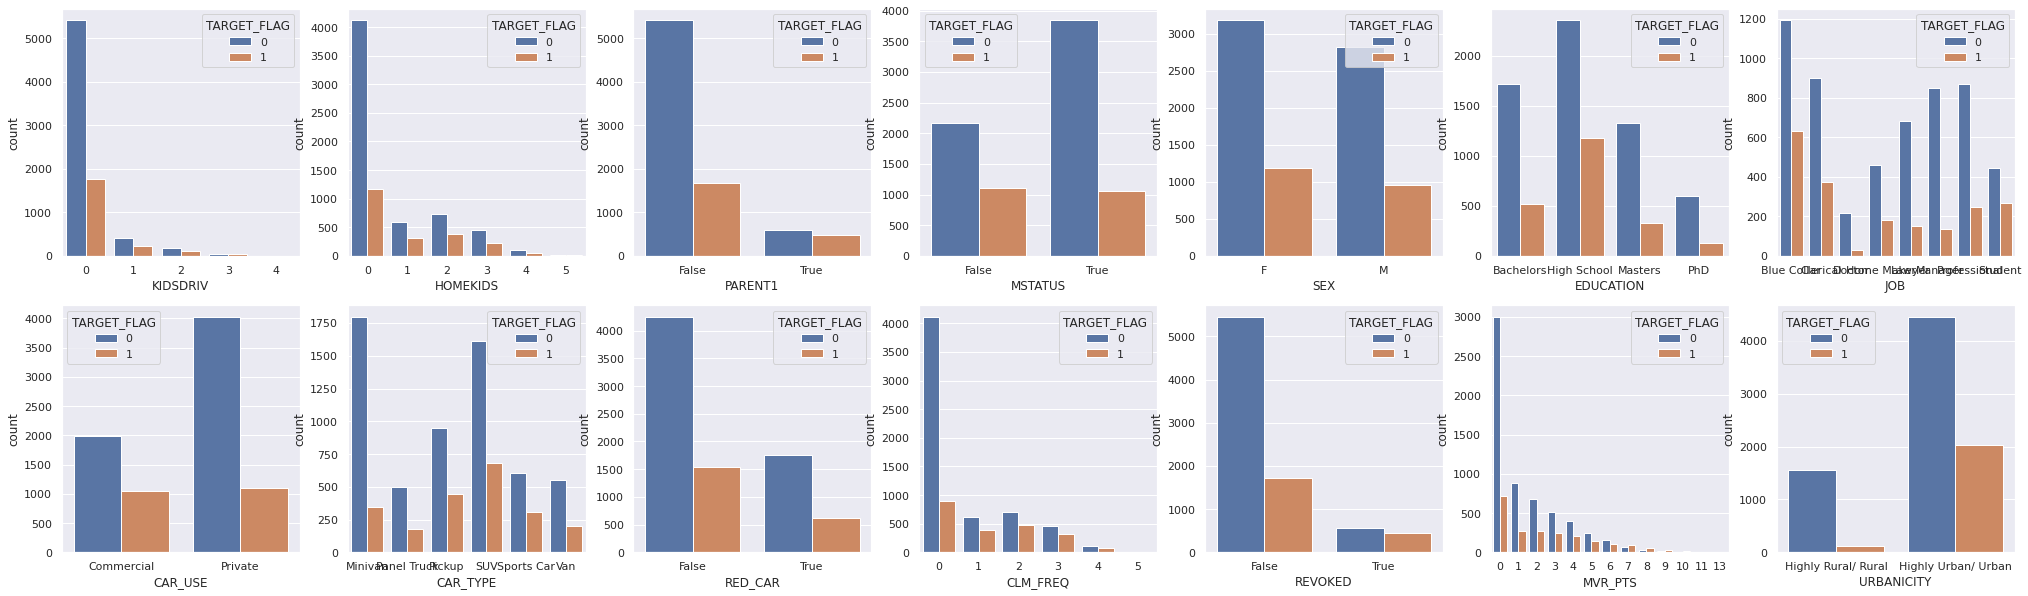

In [23]:
fig, axes = plt.subplots(2, 7, figsize=(35,10))

for ax, feature in zip(axes.ravel(), assurance_df_train.select_dtypes('category').columns.values):
    sns.countplot(x = feature, hue = 'TARGET_FLAG', data = assurance_df_train, ax= ax)

And how the numerical ones relate to the target variable.

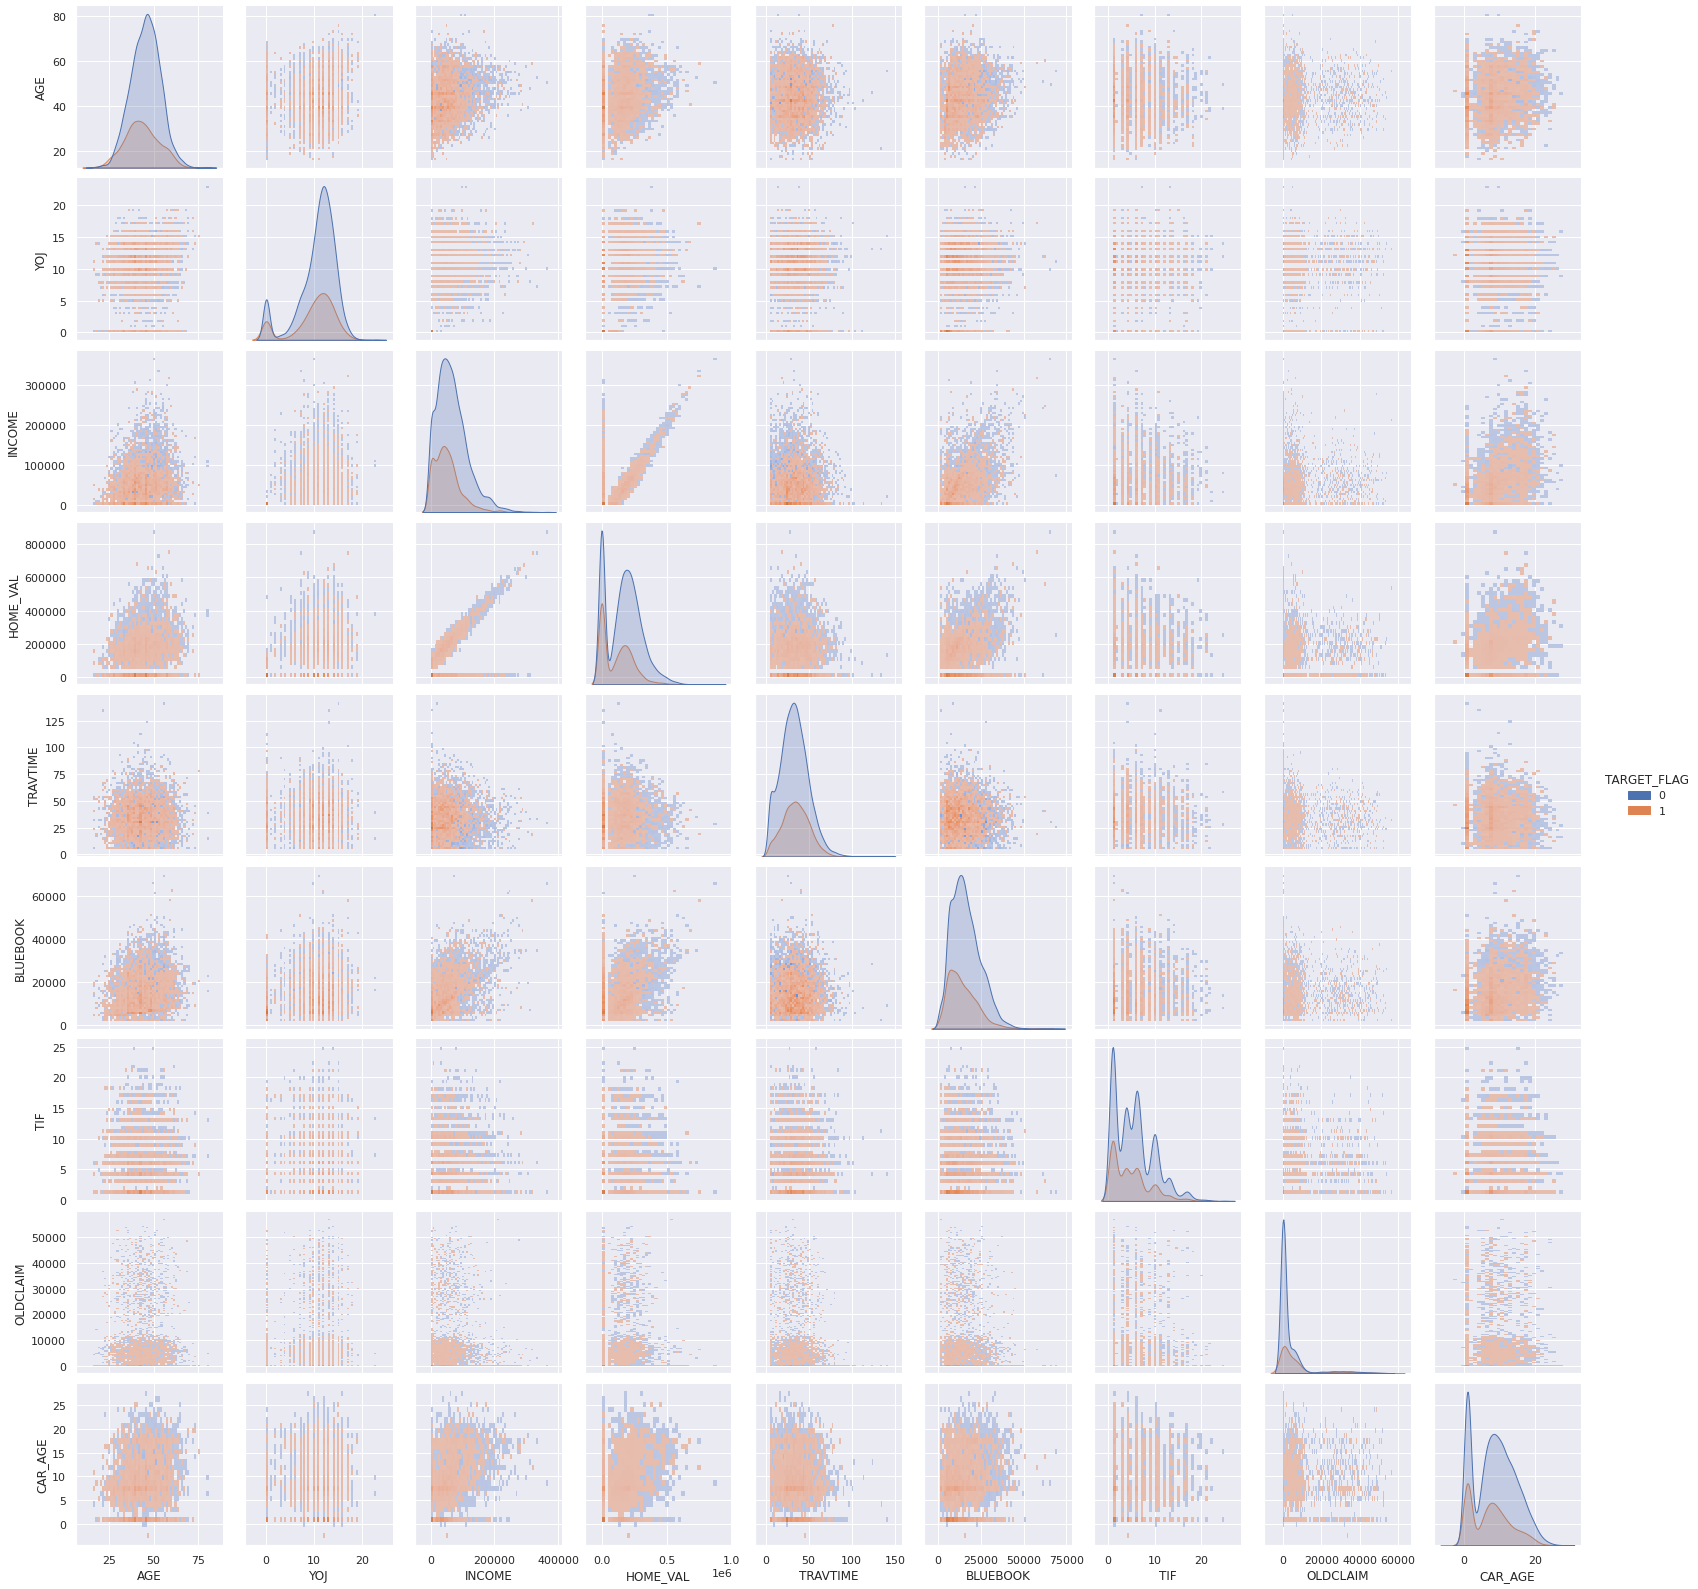

In [22]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_features = assurance_df_train.select_dtypes(include=numerics)
sns.set(rc={'figure.figsize':(450,430)})
sns.pairplot(numerical_features, diag_kind='kde', kind = 'hist', hue = 'TARGET_FLAG')   

The amount positive and negative values for each feature looks balanced, so we could infer there is no bias in this sense.

Another issue is the missing the data for some features, in order to handle this problem, the first step is to take a closer look at the data by calculating the percentage of missing data in each feature and in the whole dataset:

In [24]:
print("The percentage of missing data for each feature:")
(100* (assurance_df_train.isnull() | assurance_df_train.isna()).sum()/len(assurance_df_train)).round(2)

The percentage of missing data for each feature:


TARGET_FLAG    0.00
KIDSDRIV       0.00
AGE            0.07
HOMEKIDS       0.00
YOJ            5.56
INCOME         5.45
PARENT1        0.00
HOME_VAL       5.69
MSTATUS        0.00
SEX            0.00
EDUCATION      0.00
JOB            6.45
TRAVTIME       0.00
CAR_USE        0.00
BLUEBOOK       0.00
TIF            0.00
CAR_TYPE       0.00
RED_CAR        0.00
OLDCLAIM       0.00
CLM_FREQ       0.00
REVOKED        0.00
MVR_PTS        0.00
CAR_AGE        6.25
URBANICITY     0.00
dtype: float64

In [25]:
print(f"{(100*((assurance_df_train.isnull() | assurance_df_train.isna()).sum().sum()/assurance_df_train.size)).round(2)}% of the entire data is missing")

1.23% of the entire data is missing


As we can see from these values, the amount of missing data is not huge compared to the whole dataset. However, when inspected closely, we see that apart from for 'AGE' (0.07%), for 'YOJ', 'INCOME', 'HOME_VAL', 'JOB' and 'CAR_AGE' this percentage rises up to around 5-6%.

To pick which strategy to handle these missing values, we need to estimate the missingness mechanisms we are dealing with. These can be grouped into three categories: 

* **Missing Completely At Random (MCAR)**
    * There is no relationship between the missing data and observed or missing values
* **Missing At Random (MAR)**
    * There is a systematic relationship between the propensity of missing values and the observed data, but not the missing data
* **Missing Not At Random (MNAR)**
    * There is a relationship between the missingness of the data and its values
 
To determine if the missing data is MNAR, one would have to ideally have information on the missing data, e.g. why the data is missing, which we don't. There is nothing in the data that could tell us it is MNAR. 

It is worth checking the mechanism for each feature with missing data, because it might not be the same for all of them. Since the number of features is large and in order not to diverge too much from the scope of this assignment, we may check for MAR, i.e. if the missingness can be related to the observed data. If proved true, a method to deal with it would be Multiple Imputation, which also works for MCAR. We could then, as a rule of thumb, apply it to all missing data.

First, we could check if the missingness has any correlation with the missing data, which is the case by observing the heatmap below. This result may point out to MCAR or MAR mechanisms.

<AxesSubplot:>

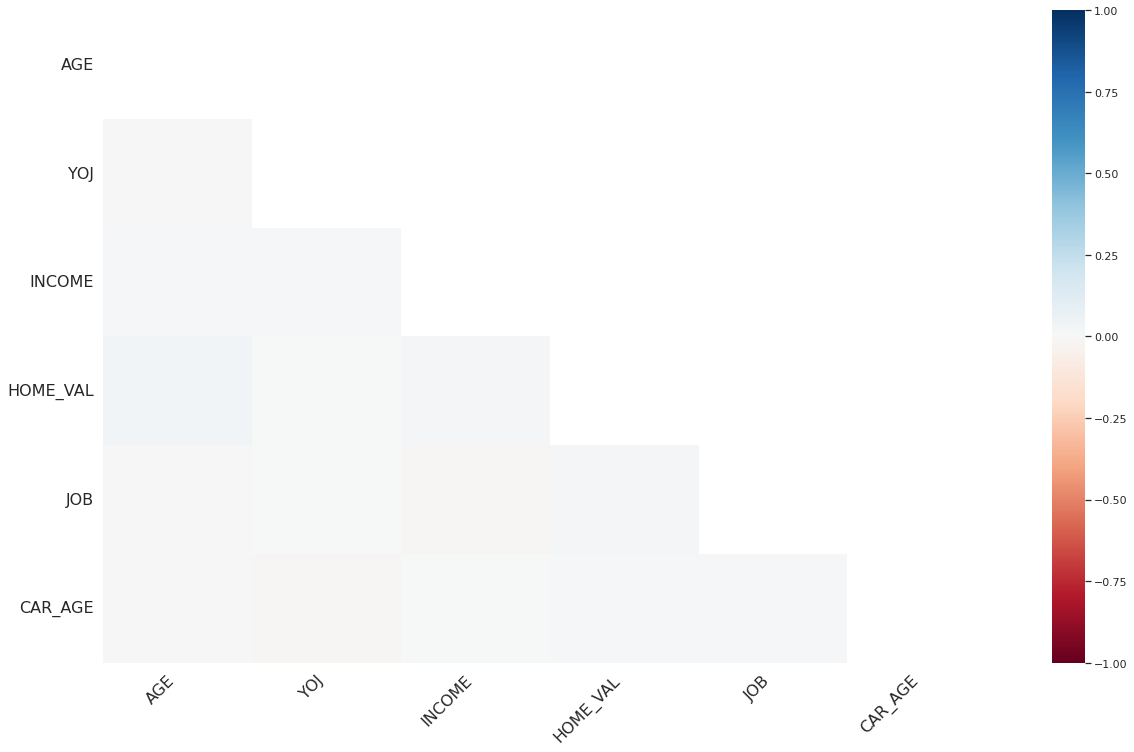

In [26]:
msno.heatmap(assurance_df_train)

We may make an educated guess and start our analysis with the 'JOB' feature. The missingness of this data might be related to other features in our dataset, probably categorical ones, e.g. EDUCATION and SEX. At a first look it does seem randomly scattered, just as all the other features for which data is missing.

<AxesSubplot:>

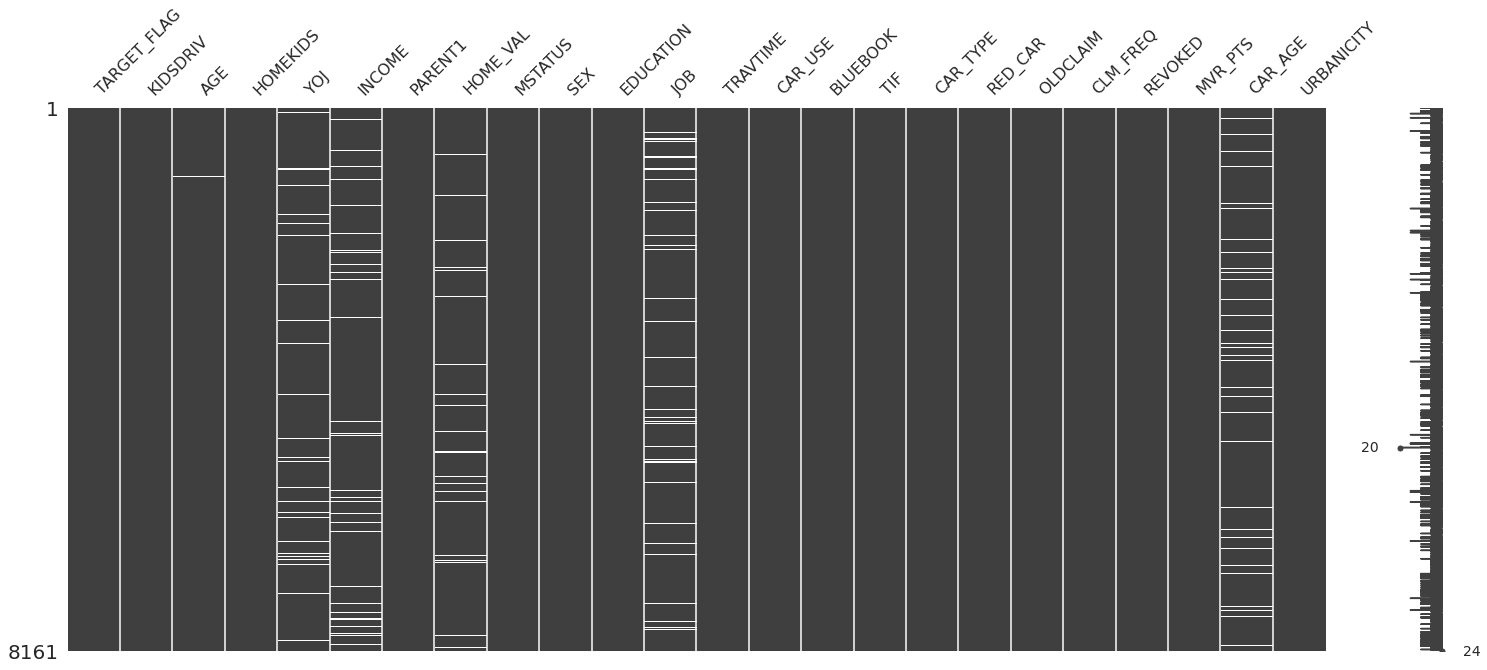

In [29]:
msno.matrix(assurance_df_train)

If we isolate its null values and compare them to the rest of the observations for categorical features, we realize that the top values change regarding 'SEX', 'EDUCATION', 'CAR_USE' and 'CAR_TYPE'.

In [30]:
missing_survey = assurance_df_train[assurance_df_train['JOB'].isna()]
complete_survey = assurance_df_train[~assurance_df_train['JOB'].isna()]

complete_survey.describe(include=['category'])

,KIDSDRIV,HOMEKIDS,PARENT1,MSTATUS,SEX,EDUCATION,JOB,CAR_USE,CAR_TYPE,RED_CAR,CLM_FREQ,REVOKED,MVR_PTS,URBANICITY
count,7635,7635,7635,7635,7635,7635,7635,7635,7635,7635,7635,7635,7635,7635
unique,5,6,2,2,2,4,8,2,6,2,6,2,13,2
top,0,0,False,True,F,High School,Blue Collar,Private,SUV,False,0,False,0,Highly Urban/ Urban
freq,6694,4882,6601,4593,4270,3533,1825,5078,2276,5510,4722,6698,3484,5987


In [31]:
missing_survey.describe(include=['category'])

,KIDSDRIV,HOMEKIDS,PARENT1,MSTATUS,SEX,EDUCATION,JOB,CAR_USE,CAR_TYPE,RED_CAR,CLM_FREQ,REVOKED,MVR_PTS,URBANICITY
count,526,526,526,526,526,526,0,526,526,526,526,526,526,526
unique,4,5,2,2,2,2,0,2,6,2,6,2,11,2
top,0,0,False,True,M,Masters,NaN,Commercial,Panel Truck,False,0,False,0,Highly Urban/ Urban
freq,486,407,483,301,421,328,NaN,472,241,273,287,463,228,505


We can confirm it by sorting the missing values by the categories listed above. For 'EDUCATION', 'SEX' and 'CAR_USE', we could deduce there is some relationship between their observed values and missing data from 'JOB'. Meaning we could have MAR, and the data missigness is not completely random, rulling out techniques that would handle only MCAR. So, we can procede by using the Multiple Imputation technique in order to deal with the missing data.

<AxesSubplot:>

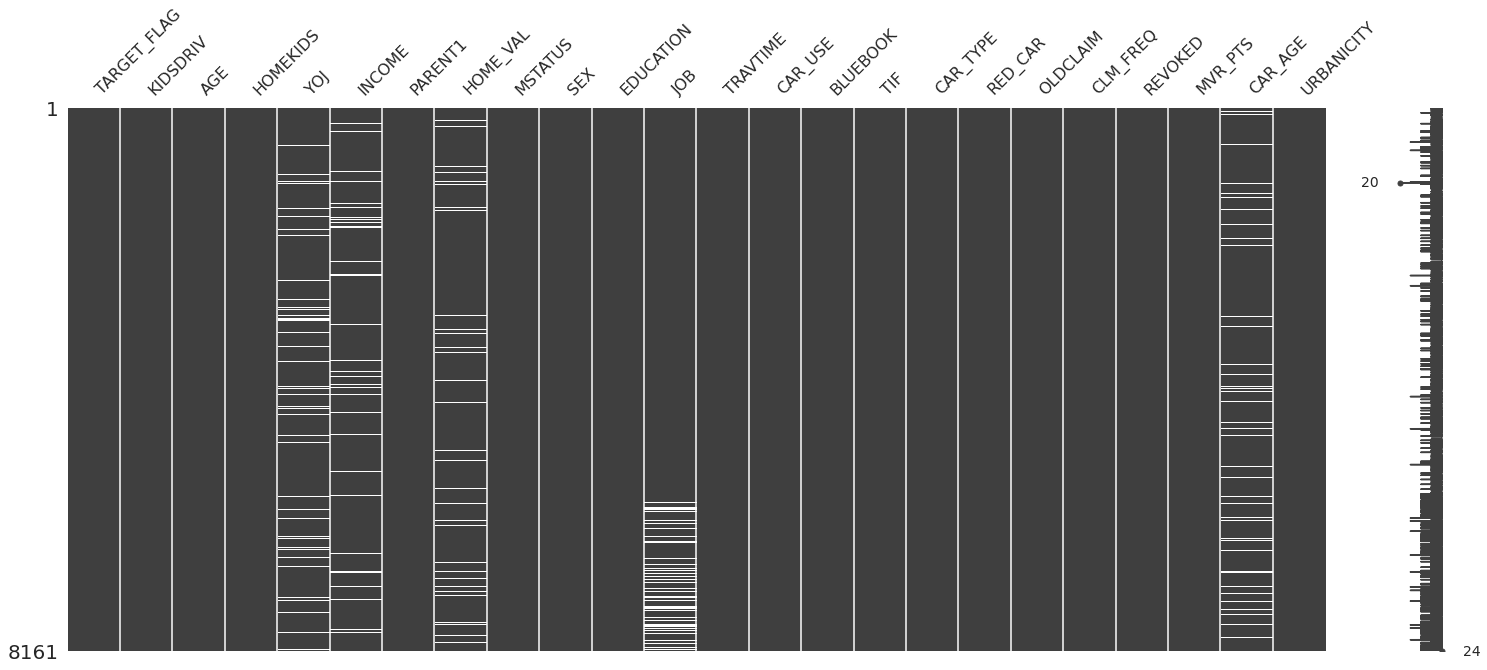

In [32]:
msno.matrix(assurance_df_train.sort_values('EDUCATION'))

By plotting these features distributions, we notice that the majority is rather skewed, which also points us to a Multiple Imputation approach.

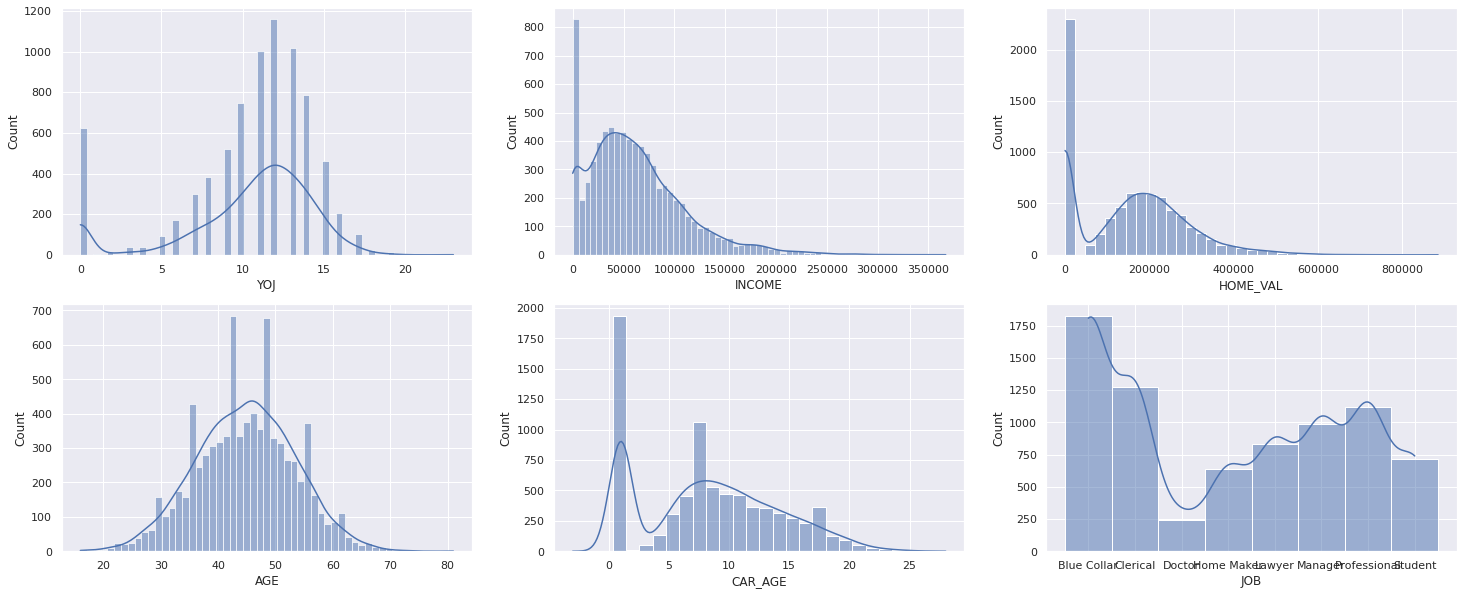

In [33]:
fig, axes = plt.subplots(2, 3, figsize=(25,10))
features_to_plot = ["YOJ", "INCOME", "HOME_VAL", "AGE", "CAR_AGE", "JOB"]

for ax, feature in zip(axes.ravel(), features_to_plot):
    sns.histplot(data=assurance_df_train, x=feature, kde=True, ax=ax)

We notice that for "CAR_AGE" there are negative values in the dataset, which does not make much sense in this case. This is also seen in the list of unique values per feature printed at the beginning of the notebook, we see there the value -3. Since, we cannot say if the minus before the number was a type error or not, it would be safer to set these values to NaN.

In [34]:
assurance_df_train.loc[assurance_df_train["CAR_AGE"] < 0, "CAR_AGE"] = np.nan
assurance_df_test.loc[assurance_df_test["CAR_AGE"] < 0, "CAR_AGE"] = np.nan

## 2- Feature Engineering

We begin this section by tackling the missing value issue discussed in the previous one.

To impute the missing data for the categorical features, e.g. 'YOJ', 'JOB' and 'CAR_AGE', we will fill the missing values with the most frequent value.
For the time being, we will create a copy of our training data in order to check if the variables distributions were not changed by much after the imputation step.

Also for visualization purpose, we will show step by step of the data processing, instead of condensing everything using scikit-learn Pipeline framework.

In [35]:
assurance_df_train_imp = assurance_df_train.copy(deep = True)

In [36]:
simple_imputer = SimpleImputer(missing_values=np.NaN, strategy='most_frequent')
categorical_features_missing = ['YOJ', 'JOB', 'CAR_AGE']
for feature in categorical_features_missing:
    assurance_df_train_imp[feature] = simple_imputer.fit_transform(assurance_df_train_imp[[feature]])

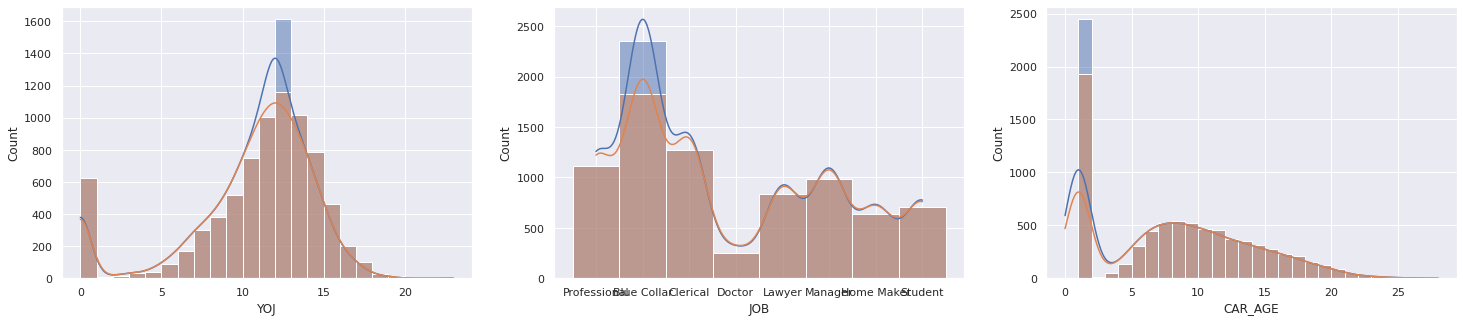

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(25,5))

for ax, feature in zip(axes.ravel(), categorical_features_missing):
    if feature == 'JOB':
        sns.histplot(data=assurance_df_train_imp, x=feature, kde=True, ax=ax)
        sns.histplot(data=assurance_df_train, x=feature, kde=True, ax=ax)
    else:
        min_bin = int(assurance_df_train_imp[feature].min())
        max_bin = int(assurance_df_train_imp[feature].max())
        sns.histplot(data=assurance_df_train_imp, x=feature, bins=range(min_bin, max_bin, 1), kde=True, ax=ax)
        sns.histplot(data=assurance_df_train, x=feature, bins=range(min_bin, max_bin, 1), kde=True, ax=ax)

We see that their distributions were not affected by much, so we may keep them as they are. 

### Encode Categorical Features
Next step is to encode the categorical features which have string values so they may not only be used by Multiple Imputation techniques to fill up the missing values for numerical features, but also because scikit-learn ML algorithms cannot handle this dtype.

We will encode our categorical data accordingly:
* **OrdinalEncoder** for categories which have a natural ranking status, e.g. 'EDUCATION' 
* **One-Hot-Encoder** where no ordinal relationship exists, e.g. 'SEX', 'CAR_USE', 'CAR_TYPE', 'URBANICITY' 

The boolean categorical features 'PARENT1', 'MSTATUS', 'RED_CAR' and'REVOKED' will be mapped to binary values.


In [38]:
boolean_features = ['PARENT1', 'MSTATUS', 'RED_CAR','REVOKED']
for feature in boolean_features:
    assurance_df_train_imp[feature] = assurance_df_train_imp[feature].astype(int)
    assurance_df_test[feature] = assurance_df_test[feature].astype(int)

In [39]:
ordinal_category = ['EDUCATION']
education_order = ['High School', 'Bachelors', 'Masters', 'PhD']
ordinal_encoder = OrdinalEncoder(categories = [education_order])
assurance_df_train_imp[ordinal_category] = ordinal_encoder.fit_transform(assurance_df_train_imp[ordinal_category])
assurance_df_test[ordinal_category] = ordinal_encoder.fit_transform(assurance_df_test[ordinal_category])

In [40]:
nominal_categories = ['SEX', 'CAR_USE', 'CAR_TYPE', 'URBANICITY', 'JOB']
one_hot_encoder = ce.OneHotEncoder(handle_missing='return_nan', use_cat_names = True, return_df = True)

for feature in nominal_categories:
    one_hot_train = one_hot_encoder.fit_transform(assurance_df_train_imp[feature])
    assurance_df_train_imp = assurance_df_train_imp.drop(feature, axis = 1)
    assurance_df_train_imp = assurance_df_train_imp.join(one_hot_train)
    
    one_hot_test = one_hot_encoder.fit_transform(assurance_df_test[feature])
    assurance_df_test = assurance_df_test.drop(feature, axis = 1)
    assurance_df_test = assurance_df_test.join(one_hot_test)

As we see below, our data has now more features due to the one hot encoding of some features.

In [41]:
assurance_df_train_imp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8161 entries, 1 to 10302
Data columns (total 39 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   TARGET_FLAG                     8161 non-null   int64   
 1   KIDSDRIV                        8161 non-null   category
 2   AGE                             8155 non-null   float64 
 3   HOMEKIDS                        8161 non-null   category
 4   YOJ                             8161 non-null   float64 
 5   INCOME                          7716 non-null   float64 
 6   PARENT1                         8161 non-null   int64   
 7   HOME_VAL                        7697 non-null   float64 
 8   MSTATUS                         8161 non-null   int64   
 9   EDUCATION                       8161 non-null   float64 
 10  TRAVTIME                        8161 non-null   int64   
 11  BLUEBOOK                        8161 non-null   int64   
 12  TIF                

We are only left with two features, for which we will use the IterativeImputer of sklearn, with initial strategy 'median' because the distributions are rather skewed.

In [42]:
imputer = IterativeImputer(initial_strategy = "median")
assurance_df_train_imp = pd.DataFrame(imputer.fit_transform(assurance_df_train_imp), columns = assurance_df_train_imp.columns)

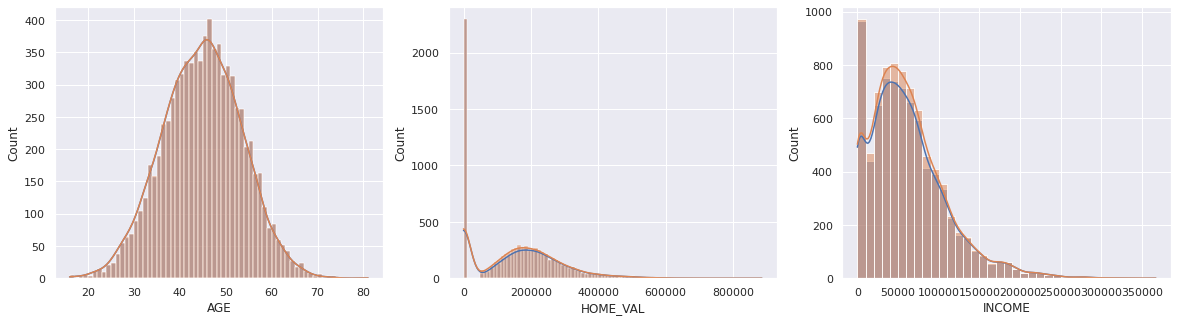

In [43]:
fig, axes = plt.subplots(1, 3, figsize=(20,5))

for ax, feature in zip(axes.ravel(), ['AGE', 'HOME_VAL', 'INCOME']):
    increment = 1 if feature == 'AGE' else 10000
    min_bin = int(assurance_df_train_imp[feature].min())
    max_bin = int(assurance_df_train_imp[feature].max())
    sns.histplot(data=assurance_df_train, x=feature, bins=range(min_bin, max_bin, increment), kde=True, ax=ax)
    sns.histplot(data=assurance_df_train_imp, x=feature,bins=range(min_bin, max_bin, increment), kde=True, ax=ax)

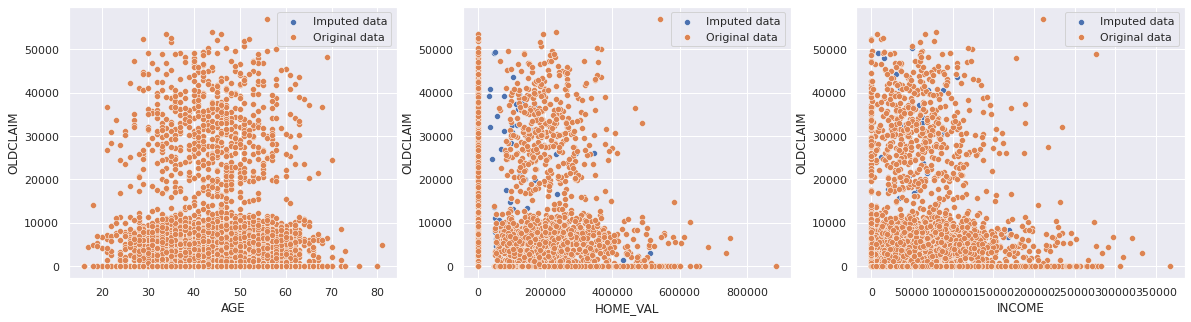

In [44]:
fig, axes = plt.subplots(1, 3, figsize=(20,5))

for ax, feature in zip(axes.ravel(), ['AGE', 'HOME_VAL', 'INCOME']):
    sns.scatterplot(x= feature , y='OLDCLAIM', data=assurance_df_train_imp, ax=ax, label= 'Imputed data')
    sns.scatterplot(x= feature , y='OLDCLAIM', data=assurance_df_train, ax=ax, label = 'Original data')

As we can see from the scatterplots, the imputed data does not diverge from the original data distribution by much.

Before we delve into feature selection, it would be recommended to normalize some features, since they have varying scales, e.g. 'INCOME' and 'HOME_VAL' are about 5000-10000 bigger than 'AGE', which could introduce bias to the model

### Data Normalization

The data range of the continous variables are very disproportional when compared to one another, so we will normalize them using MinMaxScalar from Scikit-learn.

In [45]:
assurance_df_train = assurance_df_train_imp.copy(deep = True)

In [46]:
features = np.asarray(assurance_df_train.columns.values)
for feature in features:
    print(f"Min of {feature} is {assurance_df_train[feature].min()} and max is {assurance_df_train[feature].max()}")

Min of TARGET_FLAG is 0.0 and max is 1.0
Min of KIDSDRIV is 0.0 and max is 4.0
Min of AGE is 16.0 and max is 81.0
Min of HOMEKIDS is 0.0 and max is 5.0
Min of YOJ is 0.0 and max is 23.0
Min of INCOME is 0.0 and max is 367030.0
Min of PARENT1 is 0.0 and max is 1.0
Min of HOME_VAL is 0.0 and max is 885282.0
Min of MSTATUS is 0.0 and max is 1.0
Min of EDUCATION is 0.0 and max is 3.0
Min of TRAVTIME is 5.0 and max is 142.0
Min of BLUEBOOK is 1500.0 and max is 69740.0
Min of TIF is 1.0 and max is 25.0
Min of RED_CAR is 0.0 and max is 1.0
Min of OLDCLAIM is 0.0 and max is 57037.0
Min of CLM_FREQ is 0.0 and max is 5.0
Min of REVOKED is 0.0 and max is 1.0
Min of MVR_PTS is 0.0 and max is 13.0
Min of CAR_AGE is 0.0 and max is 28.0
Min of SEX_M is 0.0 and max is 1.0
Min of SEX_F is 0.0 and max is 1.0
Min of CAR_USE_Private is 0.0 and max is 1.0
Min of CAR_USE_Commercial is 0.0 and max is 1.0
Min of CAR_TYPE_Minivan is 0.0 and max is 1.0
Min of CAR_TYPE_SUV is 0.0 and max is 1.0
Min of CAR_TYPE_S

'AGE', 'INCOME', 'HOME_VAL', 'TRAVTIME', 'BLUEBOOK' and 'OLDCLAIM' are to be normalized.

In [47]:
scaler = MinMaxScaler() 
features_to_normalize = ['AGE', 'INCOME', 'HOME_VAL', 'TRAVTIME', 'BLUEBOOK', 'OLDCLAIM']
for feature in features_to_normalize:
    assurance_df_train[feature] = scaler.fit_transform(assurance_df_train[feature].values.reshape(-1,1))
    assurance_df_test[feature] = scaler.fit_transform(assurance_df_test[feature].values.reshape(-1,1))

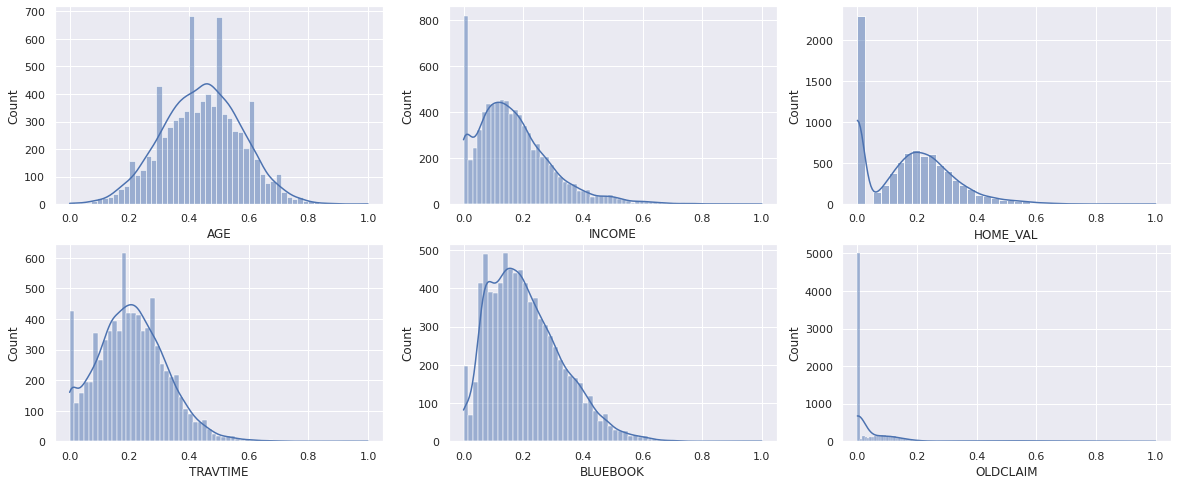

In [48]:
fig, axes = plt.subplots(2, 3, figsize=(20,8))

for ax, feature in zip(axes.ravel(), features_to_normalize):
    sns.histplot(data=assurance_df_train, x=feature, kde=True, ax=ax)

## 3- Feature Selection

Another fundamental step in the building of a ML model is the selection of features which contribute the most to the prediction variable. Adding irrelevant or partially irrelevant features to the model may have an impact on its performance, e.g. may increase its variance and hence reduce its generalization capability. 

Even though some ML models, e.g. tree-based ones, intrinsically tend to focus on the most relevant features, we will proceed with this analysis because it allows us to also use other ML methods effectively.

Since there is no best feature selection method, given our dataset, we will try three different approaches, being the first one the use of univariate feature selection with F-test for feature scoring.

In [49]:
features = assurance_df_train.drop('TARGET_FLAG',axis=1)
selector = SelectKBest(k='all')
fit = selector.fit(features, labels)
columns = pd.DataFrame(features.columns)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()
scores = pd.DataFrame(scores)

p_values = pd.DataFrame({'Feature': features.columns, 'p_value': selector.pvalues_}).sort_values('p_value')
print(p_values)

                           Feature       p_value
28  URBANICITY_Highly Urban/ Urban  1.512617e-93
29  URBANICITY_Highly Rural/ Rural  1.512617e-93
16                         MVR_PTS  2.320264e-89
14                        CLM_FREQ  6.332803e-87
6                         HOME_VAL  1.088021e-60
5                          PARENT1  1.488738e-46
15                         REVOKED  2.410252e-43
20                 CAR_USE_Private  2.252692e-38
21              CAR_USE_Commercial  2.252692e-38
4                           INCOME  4.098560e-38
13                        OLDCLAIM  4.962696e-36
8                        EDUCATION  1.652563e-35
22                CAR_TYPE_Minivan  1.729612e-35
7                          MSTATUS  1.460728e-34
2                         HOMEKIDS  1.083837e-25
35                     JOB_Manager  1.343221e-21
1                              AGE  3.267340e-21
0                         KIDSDRIV  6.052406e-21
10                        BLUEBOOK  7.741376e-21
17                  

We can also use a tree-based classifier which has an inbuilt class for feature importance.

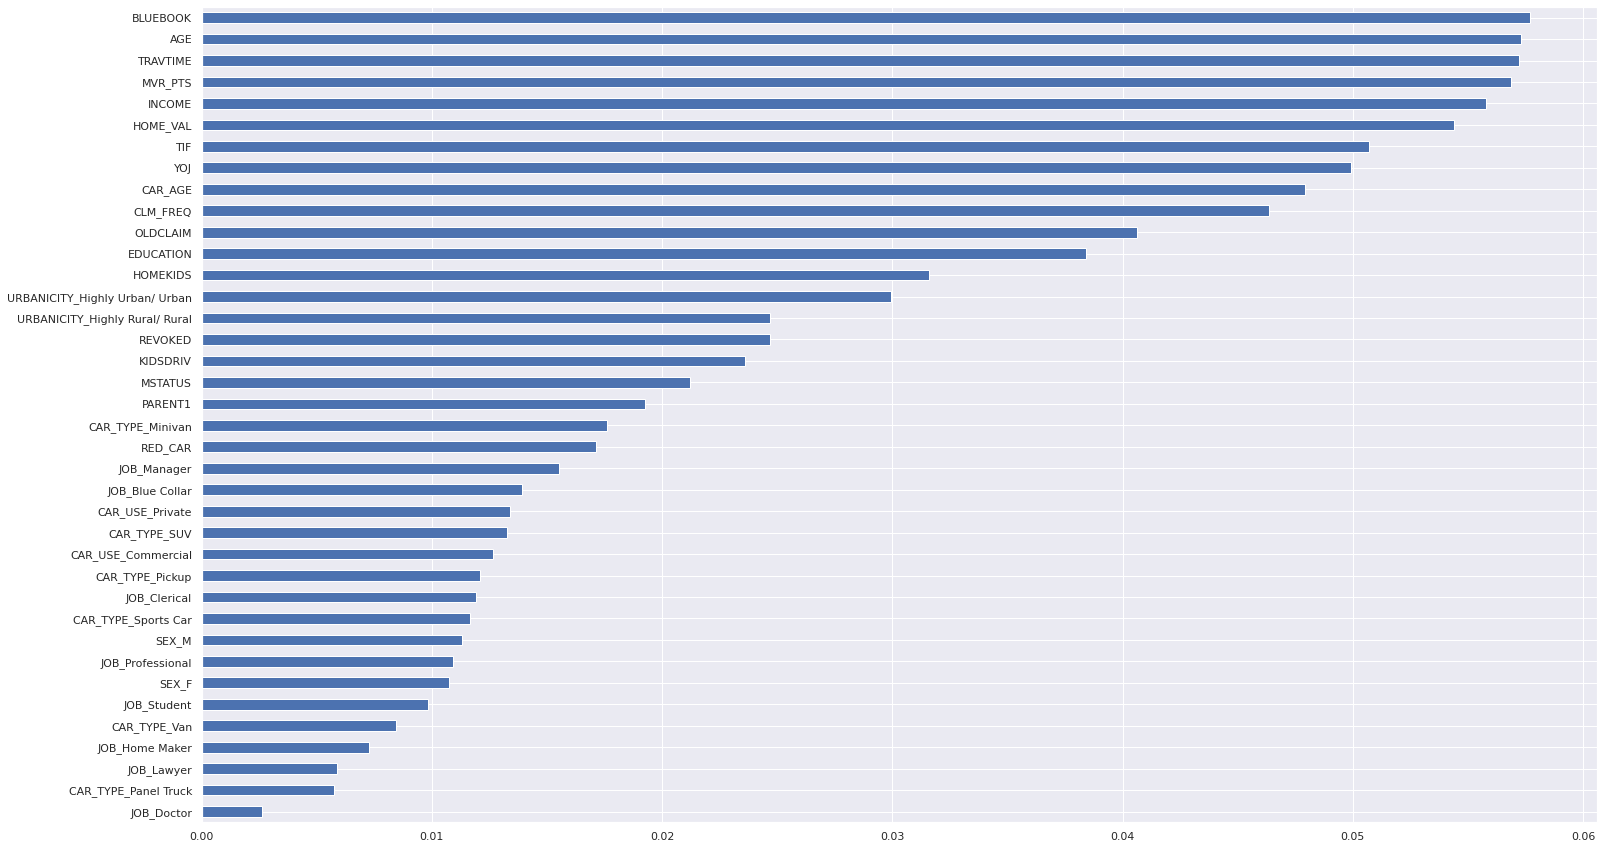

In [50]:
fig, ax = plt.subplots(figsize=(25, 15))
model = ExtraTreesClassifier()
model.fit(features, labels) 

feature_importances = pd.Series(model.feature_importances_, index=features.columns)
feature_importances.nlargest(39).plot(kind='barh').invert_yaxis()

Last, we will take a look at the correlation between the features. The features which correlate the most with the target variable are the most important ones for prediction. Moreover, the features should not be highly correlated between themselves, because we could predict one using the other, hence having them all does not give any new information to the method.

<AxesSubplot:>

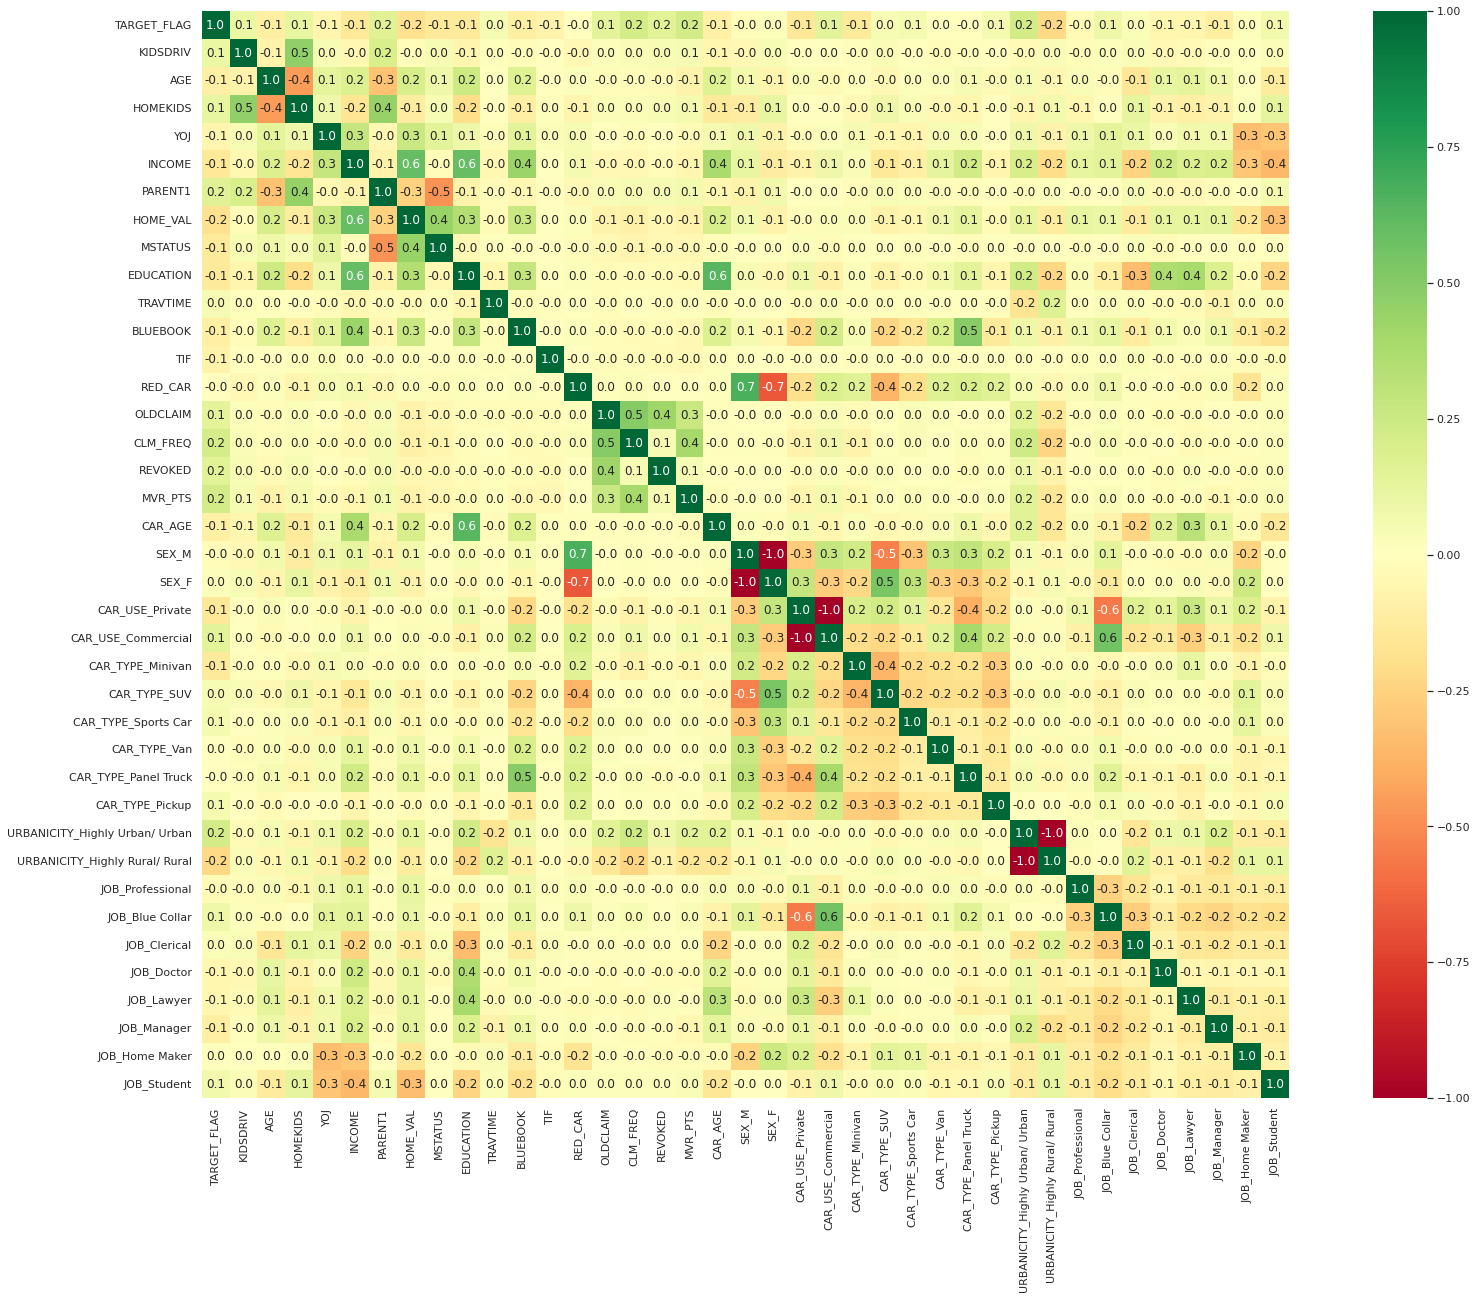

In [51]:
fig, ax = plt.subplots(figsize=(30, 20))
corr = assurance_df_train.corr()
sns.heatmap(corr, 
            cmap='RdYlGn',
            square=True,
            annot = True,
            fmt = '0.1f',
            vmin = -1.0,
            vmax = 1.0,
            ax=ax)

According to the correlation coefficients, no feature shows a high correlation with the target variable, some, e.g 'TRAVTIME', 'RED_CAR', 'SEX' 'CAR_Type(SUV, VAN, Panel Truck)' and 'JOB (Professional, Clerical, Home_Maker)' show no correlation at all. But should not be discarded for as much. The highest correlations are found for 'CLM_FREQ', 'REVOKED', 'MVR_PTS' and 'URBANICITY'. Which are also features ranking high in the first two approaches, so we are keeping them.

Based on the first approach, 'CAR_TYPE' (Van and Panel_Truck), 'RED_CAR', 'JOB' (HOME MAKER), and 'SEX' rank low. The tree-based method used ranked 'JOB', 'CAR_USE', 'CAR_TYPE', 'SEX' and 'RED_CAR' as the least important features.

Features that rank low in the three approaches are: 'RED_CAR', 'SEX', 'JOB' and 'CAR_TYPE'. Taking a closer look at the correlation map, the rectangle almost in the middle, shows that 'CAR_USE', 'CAR_TYPE' and 'SEX' are correlated between each other. 'INCOME' is highly correlated to 'EDUCATION' and 'HOME_VAL'. 

Almost all the JOBS categories show non negligible correlations with important features, e.g. with 'INCOME', 'EDUCATION', 'YOJ' and 'HOME_VAL'.  

Based on the above considerations and after reading some field information, we could drop 'SEX', 'RED_CAR'.

We take a closer look at the distributions of these 'clusters' of mildly correlated data, to check if we could indeed identify a relationship between them. But as we see inspect in the plots below, it is hard to be certain about it, so we decide not to delete any other feature. One could always return to this problem when iterating over all the steps in order to look for potential places to further increase the prediction power of the model.

In [56]:
assurance_df_train = assurance_df_train.drop('SEX_F',axis=1)
assurance_df_train = assurance_df_train.drop('SEX_M',axis=1)
assurance_df_train = assurance_df_train.drop('RED_CAR',axis=1)

In [57]:
assurance_df_test = assurance_df_test.drop('SEX_F',axis=1)
assurance_df_test = assurance_df_test.drop('SEX_M',axis=1)
assurance_df_test = assurance_df_test.drop('RED_CAR',axis=1)

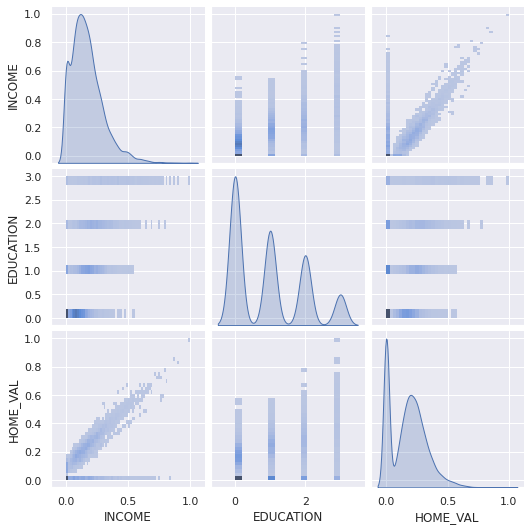

In [54]:
sns.set(rc={'figure.figsize':(450,430)})
multivariate_analysis = assurance_df_train[['INCOME', 'EDUCATION', 'HOME_VAL']]
sns.pairplot(multivariate_analysis, diag_kind='kde', kind = 'hist')   

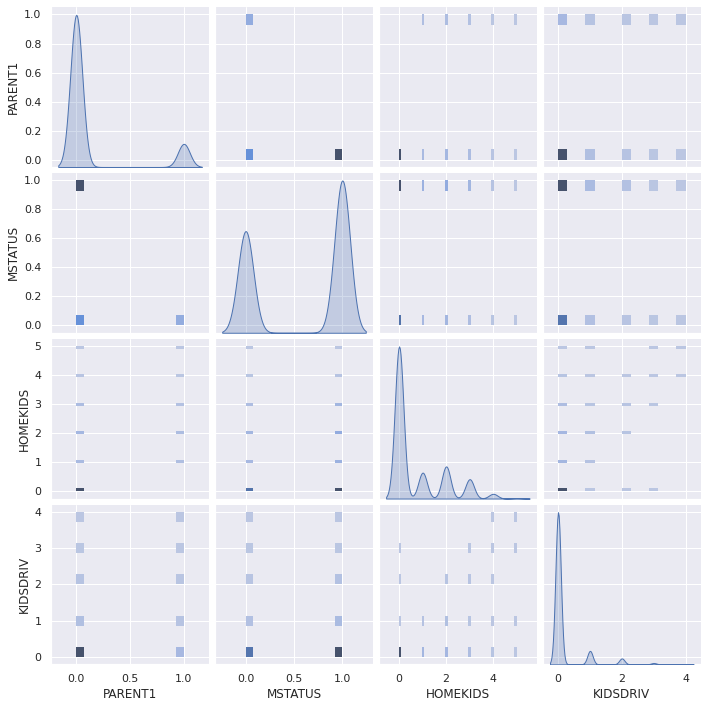

In [55]:
sns.set(rc={'figure.figsize':(350,330)})
multivariate_analysis = assurance_df_train[['PARENT1', 'MSTATUS', 'HOMEKIDS', 'KIDSDRIV']]
sns.pairplot(multivariate_analysis, diag_kind='kde', kind = 'hist')   

## Data Imbalance Check

A last check that we should run before going to the next section is to verify if there is an imbalance in the target variable classes.
In this case, we will check how much positive data we have in our labels.

<AxesSubplot:xlabel='index', ylabel='TARGET_FLAG'>

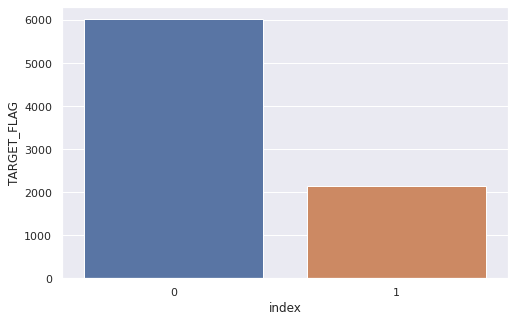

In [58]:
fig, ax = plt.subplots(figsize=(8, 5))
check_imbalance = labels.value_counts().reset_index()
sns.barplot(x = "index", y = "TARGET_FLAG", data = check_imbalance, ax= ax)

In [59]:
(labels.value_counts()/labels.count())*100

0    73.618429
1    26.381571
Name: TARGET_FLAG, dtype: float64

26.4% of the target variable is positive, meaning we have a mild to moderate imbalance in the dataset, which shouldn't in principle be a problem for a ML classifier.

## 4- Model Building

Since we are dealing with a binary classification problem, some of the ML algorithms suited for this case are tree-based one (e.g. CatBoost, XGBoost, Random Forest, Extra Trees), K-Nearest Neighbors(KNN) and Support Vector Machines(SVM). We will implement them and compare their performance.

As showed above, our target variable is imbalanced, so we choose as evaluation metrics, f1-score which is a combination of Precision-Recall metrics, the first is calculated by dividing the true positives values by anything that was predicted as a positive and the last is calculated by dividing the true positives values by anything that should have been predicted as positive. We will also use a modified 'accuracy' metric called 'balanced_accuracy' by scikit-learn, which is the mean of the sensitivity (true positive rate) and specificity(true negative rate).

To save us time, we will train all these classifiers without optimizing their hyperparameters and check how well they perform. To evaluate their performance on our problem and to select an appropriate model to predict our test data, we will use k-fold cross validation, with k = 10 (number of times the training data is split).

In [60]:
scoring = ['precision', 'recall', 'f1', 'balanced_accuracy']

classifiers = dict(SVC = SVC(),
                   KNC = KNeighborsClassifier(),
                   RFC = RandomForestClassifier(),
                   ETC = ExtraTreesClassifier(),
                   CBC = CatBoostClassifier(verbose = 0),
                   XGB = xgb.XGBClassifier(),
                   LGBM = lgb.LGBMClassifier()
                  )

In [61]:
X_train = assurance_df_train.drop('TARGET_FLAG',axis=1)
y_train = labels

In [62]:
def cv_ML_algorithms(X_train, y_train, classifiers, scoring, cv):
    
    classifiers_cv_results = {}
    for classifier_name, classifier in classifiers.items():
        classifier_cv = cross_validate(classifier, 
                       X_train, 
                       y_train, 
                       scoring=scoring, 
                       cv=cv,  
                       return_train_score=True, 
                       return_estimator=True,
                       n_jobs=-1
                      )
        classifiers_cv_results[classifier_name] = classifier_cv
        
    return classifiers_cv_results

In [63]:
classifiers_cv_results_array = cv_ML_algorithms(X_train, y_train, classifiers, scoring, 10)

<AxesSubplot:xlabel='evaluation_metrics', ylabel='value'>

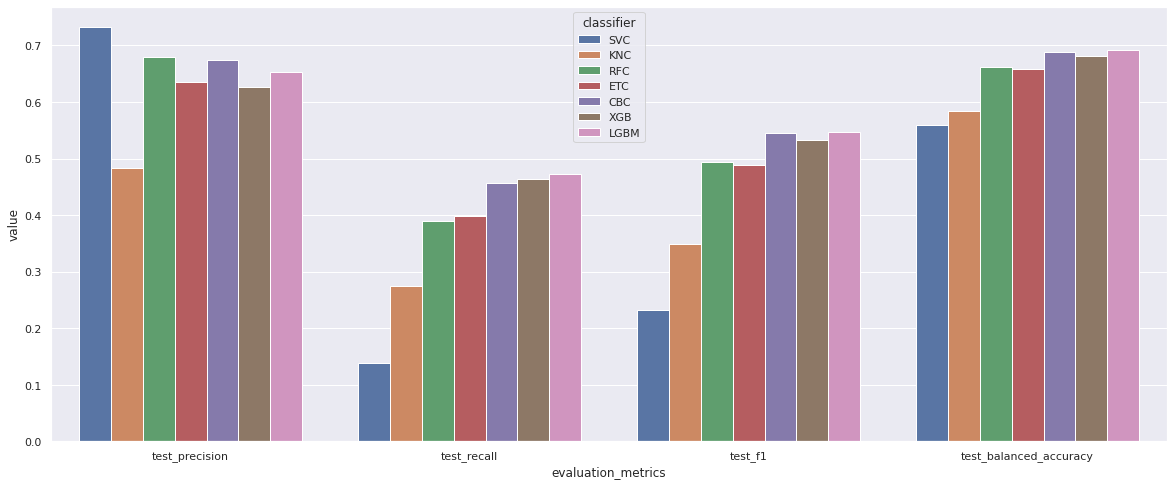

In [64]:
classifiers_cv_results = pd.DataFrame(classifiers_cv_results_array).transpose()
classifiers_cv_results = classifiers_cv_results.reset_index().rename(columns={'index': 'classifier'})

classifiers_cv_results.drop([
        'fit_time', 'score_time', 'estimator', 'train_precision', 
        'train_recall', 'train_f1', 'train_balanced_accuracy'], 
        axis=1, inplace=True
    )

for column in ['test_precision', 'test_recall', 'test_f1', 'test_balanced_accuracy']:
        classifiers_cv_results[column] = classifiers_cv_results[column].map(lambda row: row.mean())
   
data_to_plot = classifiers_cv_results.melt(id_vars= 'classifier', 
                                    value_vars = classifiers_cv_results.columns[[1, 2, 3, 4]],
                                    var_name= 'evaluation_metrics')
fig, ax = plt.subplots(figsize=(20, 8))
sns.barplot(x = 'evaluation_metrics', y = 'value', hue = 'classifier', data = data_to_plot, ax = ax)

Based at evaluation metrics that we obtained for each ML algorithm, we can see that the three boosting algorithms, XGBoost, CatBoost and LightGBM have the best overall performances. They are only surpassed by the Support Vector Machine (SVM) and Random Forest (not by much) at precision. But on the other hand, SVM ranks the lowest for the other metrics. KNN does not outstand any other classifier at any of the chosen metrics, whilst the tree-based Random Forest and Extra Tree classifiers are not that far behind the optimized boosting techniques peers.

After these considerations, we will choose the CatBoostClassifier due to its robust results, even though choosing LGBM or XGBoost would also be a good fit for our dataset, given that, in general, they deal well with umbalanced data.

## 5- Hyperparameter tuning

In this section, we will optimize the hyperparameters of the CatBoostClassifier using the RandomizedSearchCV technique by scikit-learn. This method uses cross-validation search over the parameters settings to optimize them.

In [66]:
cbc_param_cv = dict(
    bootstrap_type = ['Bayesian', 'Bernoulli'], 
    iterations = sp_randInt(100,300),
    learning_rate = sp_randFloat(0.01, 0.08) , 
    depth = sp_randInt(5,10),
    l2_leaf_reg = sp_randInt(3,9),
    #bagging_temperature = sp_randFloat(0.0, 1),
    loss_function = ['Logloss', 'CrossEntropy']
                               )

cbc_rand_cv = RandomizedSearchCV(CatBoostClassifier(verbose = 0), 
                                 cbc_param_cv, 
                                 scoring= scoring, 
                                 n_iter = 25,
                                 refit = 'f1',
                                 n_jobs = -1,
                                 random_state = 60
                                )
cbc_search = cbc_rand_cv.fit(X_train, y_train)
cbc_search.best_params_

{'bootstrap_type': 'Bernoulli',
 'depth': 6,
 'iterations': 211,
 'l2_leaf_reg': 6,
 'learning_rate': 0.08712783302716488,
 'loss_function': 'Logloss'}

<AxesSubplot:xlabel='evaluation_metrics', ylabel='value'>

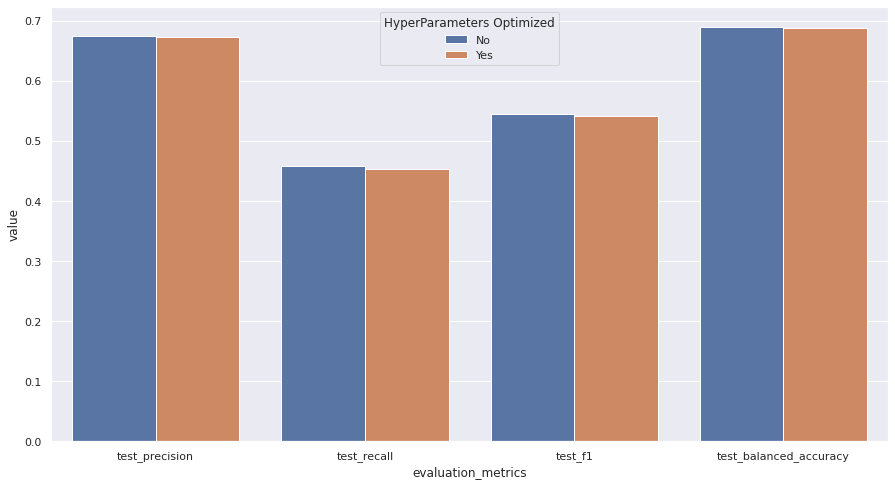

In [67]:
cbc_cv_results = classifiers_cv_results.copy(deep = True)
cbc_cv_results.drop(classifiers_cv_results[classifiers_cv_results['classifier'] != 'CBC'].index, axis = 0, inplace = True)
cbc_cv_results.drop(['classifier'], axis = 1, inplace = True)
cbc_cv_results.insert(4, "HyperParameters Optimized", ['No'], True)
cbc_cv_hyperparams_row = pd.DataFrame([{'test_precision' : cbc_search.cv_results_['mean_test_precision'][cbc_search.best_index_],
                         'test_recall' : cbc_search.cv_results_['mean_test_recall'][cbc_search.best_index_],
                         'test_f1' : cbc_search.best_score_,
                         'test_balanced_accuracy': cbc_search.cv_results_['mean_test_balanced_accuracy'][cbc_search.best_index_],
                         'HyperParameters Optimized': 'Yes'}])
cbc_cv_results = pd.concat([cbc_cv_results, cbc_cv_hyperparams_row], axis = 0 , ignore_index = True)
data_to_plot = cbc_cv_results.melt(id_vars= 'HyperParameters Optimized', 
                                    value_vars = cbc_cv_results.columns[[0, 1, 2, 3]],
                                    var_name= 'evaluation_metrics')
fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(x = 'evaluation_metrics', y = 'value', hue = 'HyperParameters Optimized', data = data_to_plot, ax = ax)

We see that after optimizing the hyperparameters, the performance of the classifier does not improve much, showing that it already had a close to optimal set of hyperparameters for our dataset. We will use however the parameters found to train and test our dataset.

## 6- Testing and Final Results

In this section, we will test our optimized classifier in the provided test data. To save us time, the test data was already preprocessed alongside the train data, so we may use it right away, a more straightforward way would had been constructing a Pipeline using scikit-learn.

Let's take a look at it first to check if everything is as expected.

In [68]:
assurance_df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2141 entries, 3 to 10300
Data columns (total 36 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   TARGET_FLAG                     0 non-null      float64 
 1   KIDSDRIV                        2141 non-null   category
 2   AGE                             2140 non-null   float64 
 3   HOMEKIDS                        2141 non-null   category
 4   YOJ                             2047 non-null   float64 
 5   INCOME                          2016 non-null   float64 
 6   PARENT1                         2141 non-null   int64   
 7   HOME_VAL                        2030 non-null   float64 
 8   MSTATUS                         2141 non-null   int64   
 9   EDUCATION                       2141 non-null   float64 
 10  TRAVTIME                        2141 non-null   float64 
 11  BLUEBOOK                        2141 non-null   float64 
 12  TIF                

Although Catboost supports categorical features, we have already preprocessed them using one-hot encoding, so we won't pass them as categorical features, so we will standardize them according to our training set.

In [69]:
X_test = assurance_df_test.drop(columns={'TARGET_FLAG'}) 
features_to_numeric = assurance_df_test.select_dtypes(['category','int64']).columns.values
X_test[features_to_numeric]= assurance_df_train[features_to_numeric].apply(pd.to_numeric)

In [70]:
cbc_model = CatBoostClassifier(**cbc_search.best_params_,
                                    eval_metric =  'F1',
                                    thread_count=8,
                                    task_type='CPU',
                                    verbose = 0)


cbc_model.fit(X_train, y= y_train,
              verbose = 0)

Since the test labels were not provided in the test data, we won't be able to check the performance of our algorithm directly. Ultimately we save them to a .csv file.

In [71]:
print(f"F1 score {cbc_model.best_score_['learn']['F1']} attained in training phase.")

F1 score 0.7025557368134856 attained in training phase.


In [72]:
y_pred = cbc_model.predict(X_test)

In [73]:
y_pred_csv = pd.DataFrame(y_pred, columns=['TARGET_PREDICTIONS']).to_csv('data/prediction_auto.csv',  index = False)

In [74]:
print(f"CBC predicted: {(100 * y_pred.sum() / len(X_test)).round(2)}% as positive samples.")

CBC predicted: 14.57% as positive samples.
